In [1]:
import numpy as np
import itertools
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp
from scipy.stats import linregress

from bamf.bamfCR import *

import time

np.random.seed(12345)

# set plot parameters
params = {'legend.fontsize': 18,
          'figure.figsize': (8, 7),
          'axes.labelsize': 24,
          'axes.titlesize':24,
          'axes.linewidth':3,
          'xtick.labelsize':20,
          'ytick.labelsize':20}
plt.rcParams.update(params)
plt.style.use('seaborn-colorblind')
plt.rcParams['pdf.fonttype'] = 42

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


# Import data

In [2]:
# used later for model validation
gLV_data = pd.read_csv("gLV_data/gLV_data_for_CR.csv")

In [3]:
# get species names
species = list(gLV_data.columns.values[2:])

In [4]:
gLV_data

,Treatments,Time,s1,s2,s3,s4,s5
0,mono_exp_1,0.0,0.000000,0.000000,0.000000,0.000000,0.100000
1,mono_exp_1,8.0,0.000000,0.000000,0.000000,0.000000,0.136790
2,mono_exp_1,16.0,0.000000,0.000000,0.000000,0.000000,0.136553
3,mono_exp_2,0.0,0.000000,0.000000,0.000000,0.100000,0.000000
4,mono_exp_2,8.0,0.000000,0.000000,0.000000,0.176506,0.000000
...,...,...,...,...,...,...,...
88,exp_30,8.0,0.107088,0.265276,0.029762,0.197400,0.000000
89,exp_30,16.0,0.134985,0.279784,0.007307,0.230007,0.000000
90,exp_31,0.0,0.100000,0.100000,0.100000,0.100000,0.100000
91,exp_31,8.0,0.118131,0.308047,0.035410,0.212784,0.050059


# Define function to make predictions on test data

In [5]:
# Define function to make predictions on test data

def test_model(model, df_test, species, plot=False):
    all_treatments = df_test.Treatments.values
    unique_treatments = np.unique(all_treatments)
    numspecies = len(species)

    # save true and predicted values
    y_true = []
    y_pred = []
    y_std  = []
    test_treatments = []
    test_times = []
    all_species_names = []

    # pull a random community trajectory
    for treatment in unique_treatments:
        comm_inds = np.in1d(df_test['Treatments'].values, treatment)
        comm_data = df_test.iloc[comm_inds].copy()

        # make sure comm_data is sorted in chronological order
        comm_data.sort_values(by='Time', ascending=True, inplace=True)
        tspan = comm_data.Time.values

        # pull just the community data
        output_true = comm_data[species].values

        # run model using parameters
        x_test = np.copy(output_true[0, :])

        # test full community
        output, stdv, COV = model.predict(x_test, tspan)
        # output = model.predict_point(x_test, tspan)

        # save mid-point predictions of all species
        y_true.append(output_true[1])
        y_pred.append(output[1])
        # y_std.append(stdv[1])
        test_times.append([tspan]*numspecies)
        all_species_names += list(species)
        test_treatments += [treatment]*numspecies

        if plot:
            # increase teval
            t_eval = np.linspace(0, tspan[-1]+1)
            steps = len(t_eval)
            output, stdv, COV = model.predict(x_test, t_eval)
            # output = model.predict_point(x_test, t_eval)
            
            # plot the results
            plt.figure(figsize=(9, 6))
            ylim = 0
            for i, sp in enumerate(species):
                out = output[:,i]
                out_true = output_true[:, i]
                std = stdv[:, i]
                # if ylim < np.max([np.max(out) + np.max(std)+.1, np.max(out_true)+.1]):
                #    ylim = np.max([np.max(out) + np.max(std)+.1, np.max(out_true)+.1])
                if out[0] > 0:
                    plt.scatter(tspan, out_true, color='C{}'.format(i))
                    plt.plot(t_eval, out, label=f"Predicted {sp}", color='C{}'.format(i))
                    plt.fill_between(t_eval, out-std, out+std, color='C{}'.format(i), alpha=0.2)

            plt.xlabel("time", fontsize=16)
            plt.ylabel("Abundance", fontsize=16)
            plt.legend(loc='upper left')
            # plt.ylim([0, np.min([ylim, 3])])
            plt.title(f"Treatment {treatment} predictions")
            #plt.savefig("Kfold/Figures/{}_{}.pdf".format(dataset.replace("_",""), treatment.replace("<","")))
            #plt.close()
            plt.show()

    return np.array(test_treatments), np.array(test_times), np.array(all_species_names), np.array(y_true).ravel(), np.array(y_pred).ravel() #, np.array(y_std).ravel()


# Initialize model parameters

In [6]:
### global parameters 
n_s = len(species)
n_r = 3
n_x = n_s + n_r

# dimension of hidden layer
n_h = 3

# death rate 
d = np.ones(n_s)/100.

# map to hidden dimension
std = 1.
W = np.random.uniform(-std, std, [n_h, n_x])
b = np.random.uniform(-std, std, n_h)

# map back to C and P params
A = np.random.uniform(-std, std, [n_r, n_s, n_h])
B = np.random.uniform(0, std/100, [n_r, n_s, n_h])

# concatenate parameters 
params = np.concatenate((d, W.flatten(), b, A.flatten(), B.flatten()))
prior  = np.copy(params)

n_params = len(params)
n_params

122

# Define model

In [7]:
# using consumer resource model  
def system(t, x, params): 
    
    # species 
    s = x[:n_s]
    
    # resources
    r = x[n_s:]
    
    # unpack params 
    d = params[:n_s]
    W = np.reshape(params[n_s:n_s+n_x*n_h], [n_h, n_x])
    b = params[n_s+n_x*n_h:n_s+n_x*n_h+n_h]
    A = np.reshape(params[n_s+n_x*n_h+n_h:n_s+n_x*n_h+n_h+n_r*n_s*n_h], [n_r, n_s, n_h])
    B = np.reshape(params[n_s+n_x*n_h+n_h+n_r*n_s*n_h:n_s+n_x*n_h+n_h+2*n_r*n_s*n_h], [n_r, n_s, n_h])
    
    # map to hidden layer
    h = jax.nn.sigmoid(W@x + b)
    
    # "neural ODE"
    C = jax.nn.relu(jnp.einsum("ijk,k->ij", A, h))
    P = jax.nn.relu(jnp.einsum("ijk,k->ij", B, h))
     
    # rate of change of species 
    dsdt = s*(C.T@jnp.exp(r) - jax.nn.relu(d)) 

    # rate of change of resources 
    drdt = (P - C)@s

    return jnp.append(dsdt, drdt)

# Define observation matrix

In [8]:
# define observation matrices 
O = np.zeros([n_s, n_s+n_r])
O[:n_s,:n_s] = np.eye(n_s)
O

array([[1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0.]])

# Fit model to mono culture data

In [9]:
model = ODE(system = system, 
            dataframe=gLV_data,
            C = O,
            CRparams = params, 
            r0 = -np.ones(n_r),
            prior = prior,
            species = species,
            alpha_0=1.,
            verbose=True)

# fit to data 
t0 = time.time()
model.fit(evidence_tol=1e-3, beta_tol=1e-3)
print("Elapsed time {:.2f}s".format(time.time()-t0))

Updating precision...
Total samples: 160, Updated regularization: 8.44e-02
Total weighted fitting error: 22.529
Total weighted fitting error: 7.320
Total weighted fitting error: 4.950
Total weighted fitting error: 2.904
Total weighted fitting error: 2.332
Total weighted fitting error: 1.985
Total weighted fitting error: 1.934
Total weighted fitting error: 1.864
Total weighted fitting error: 1.830
Total weighted fitting error: 1.796
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 1.7957288785658931
       x: [-1.227e+00 -1.324e+00 ...  1.422e-02  1.215e-02]
     nit: 10
     jac: [-2.580e-01  4.233e-02 ...  3.460e-02  2.809e-02]
    nfev: 12
    njev: 12
    nhev: 10
Evidence 171.742
Updating precision...
Total samples: 160, Updated regularization: 9.01e-03
Total weighted fitting error: 12.066
Total weighted fitting error: 11.430
Total weighted fitting error: 11.183
Total weighted fitting error: 10.853
Total weighted fitting error: 10.753
 message: O

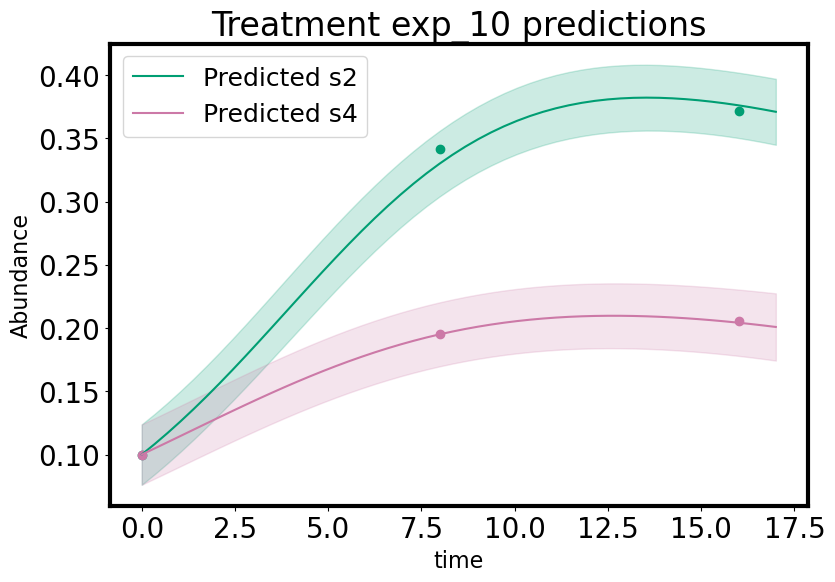

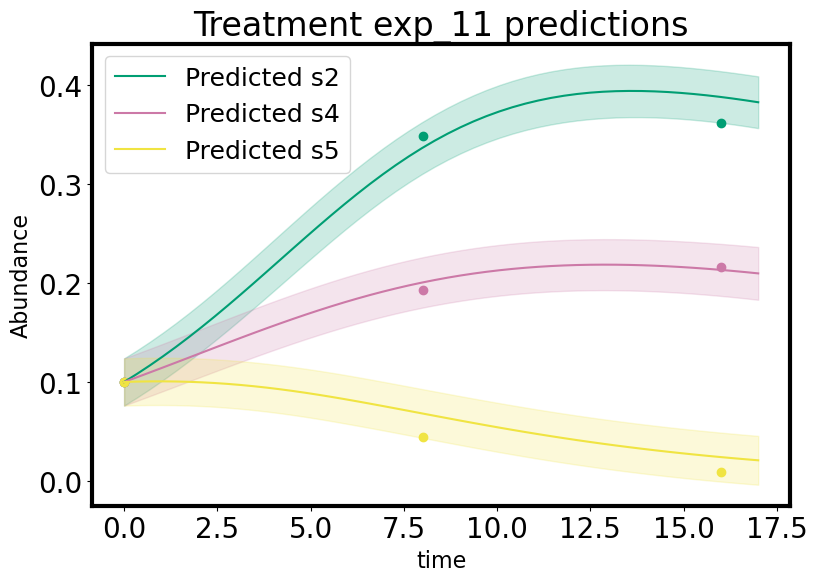

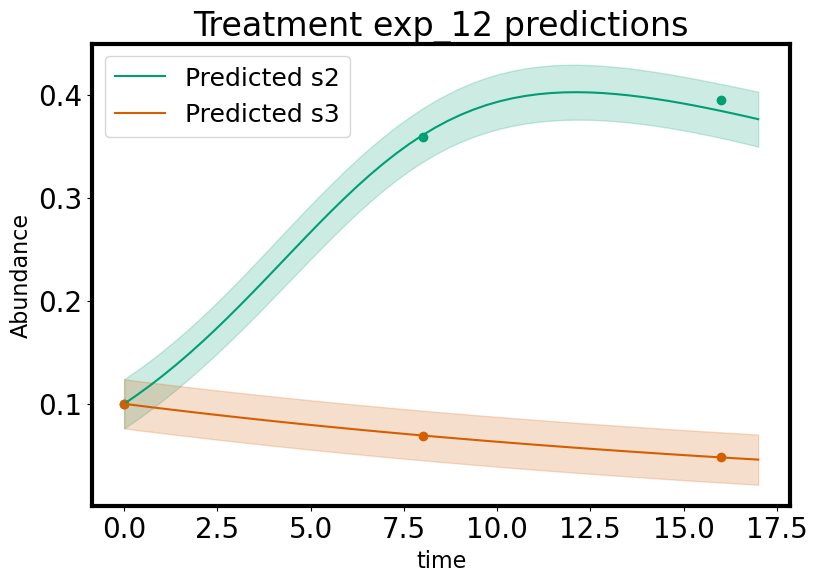

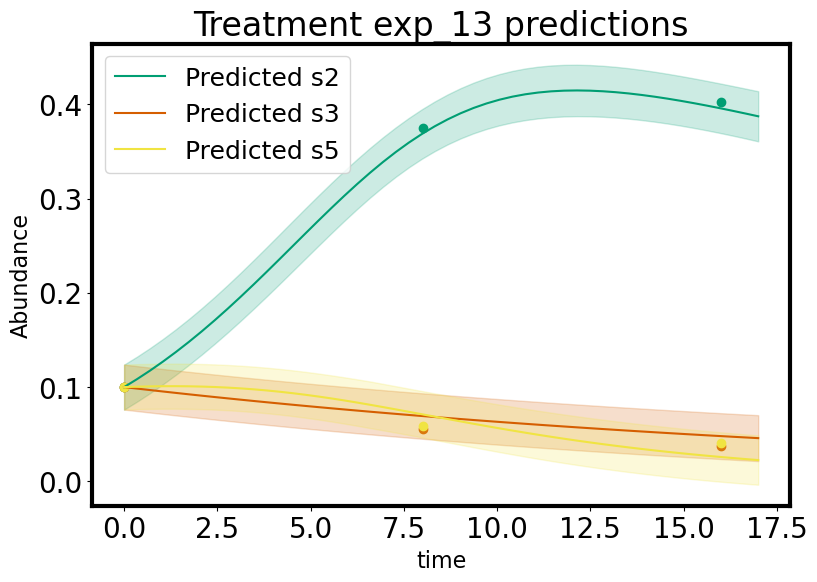

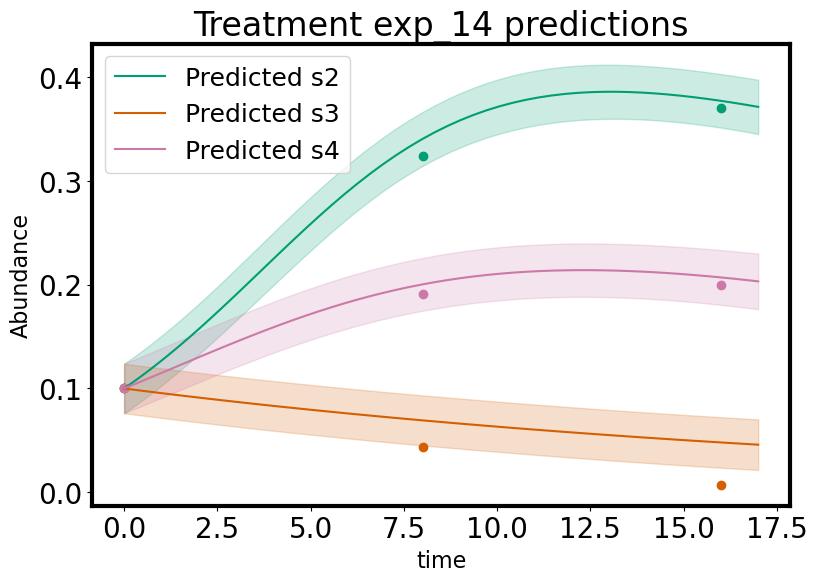

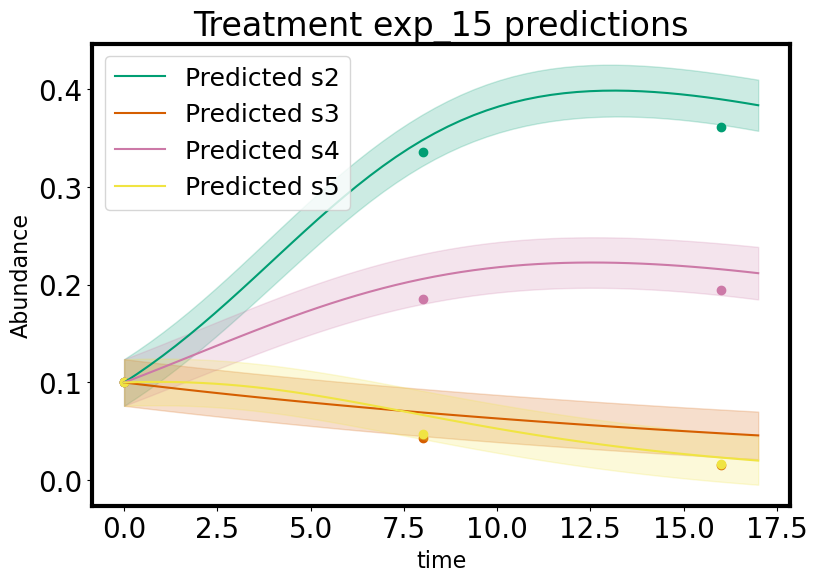

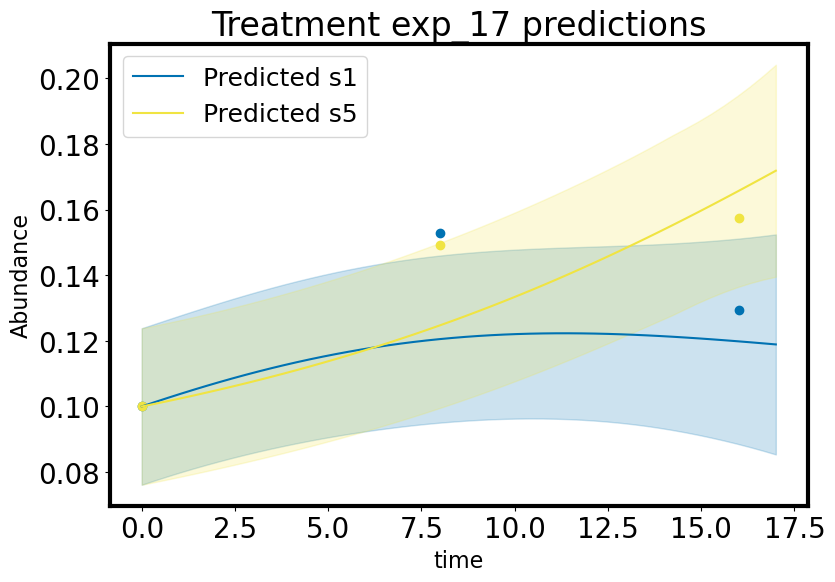

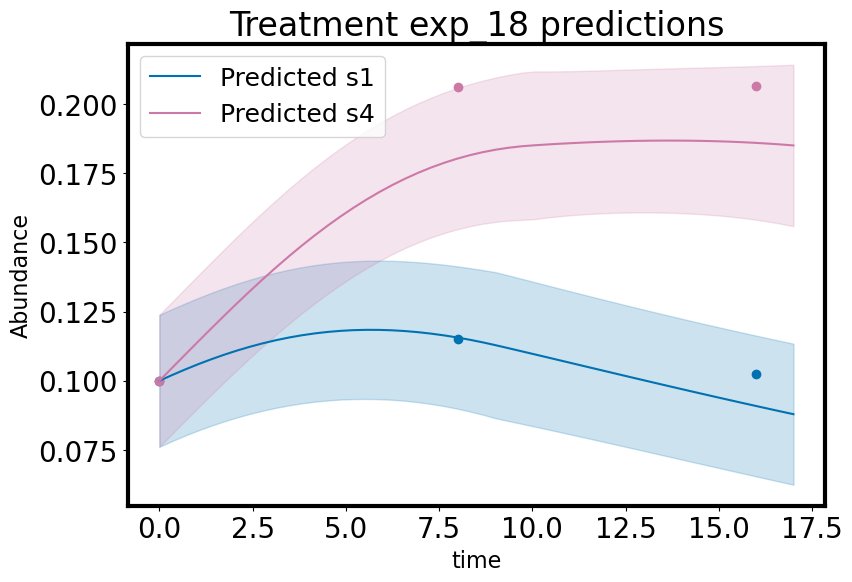

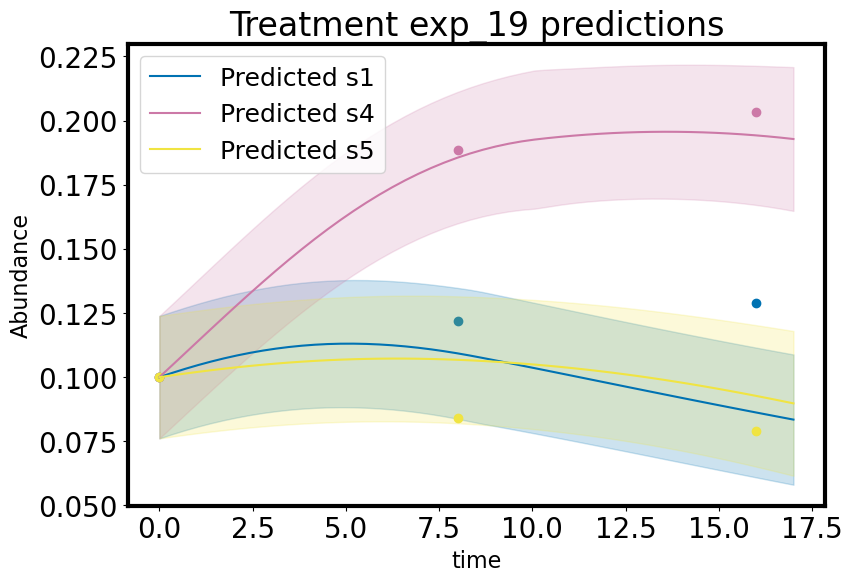

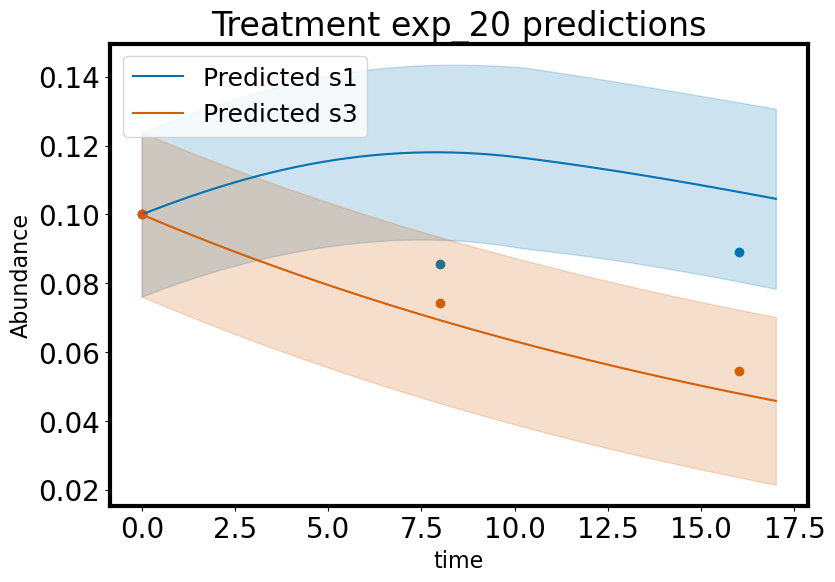

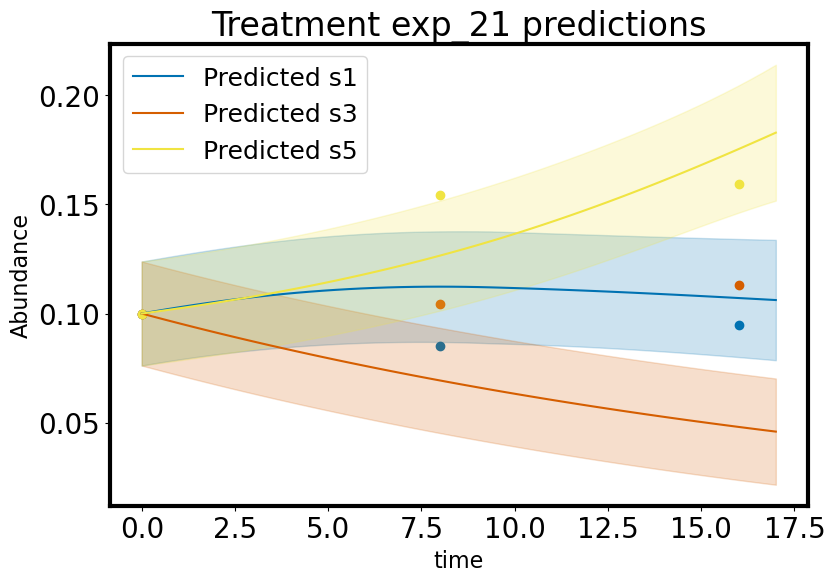

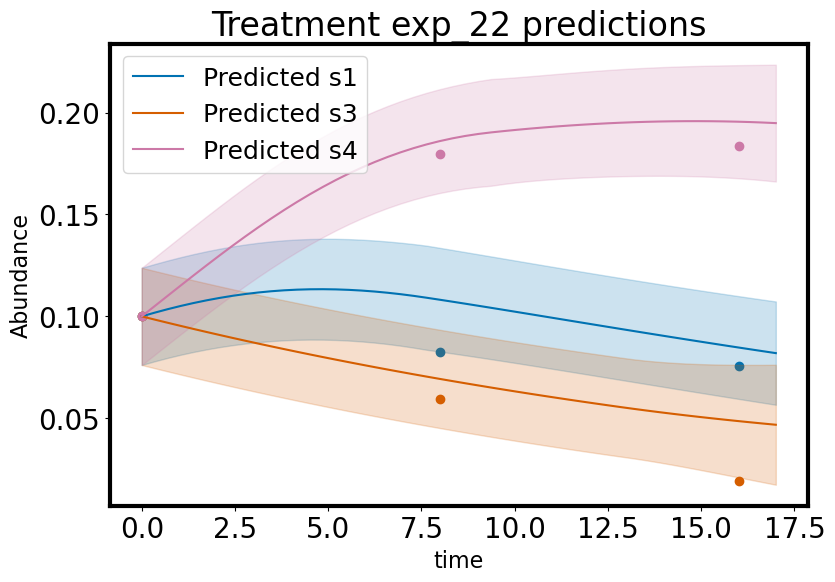

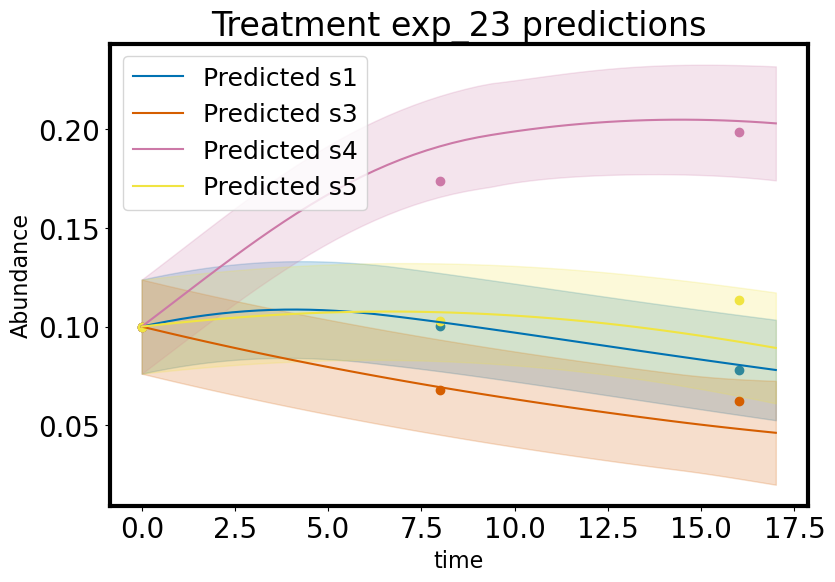

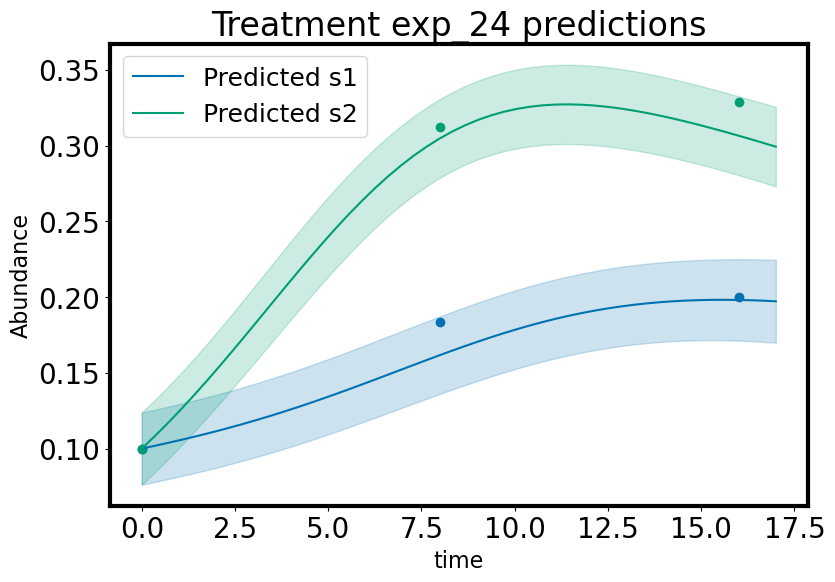

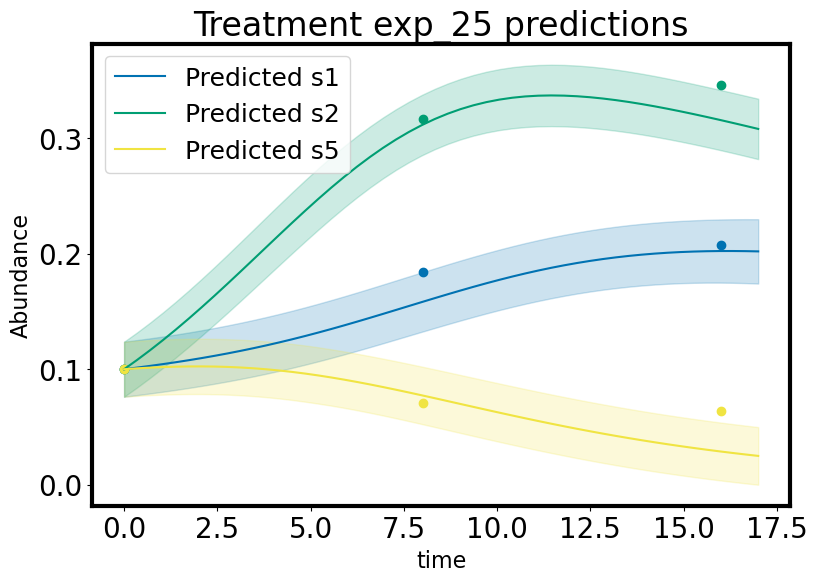

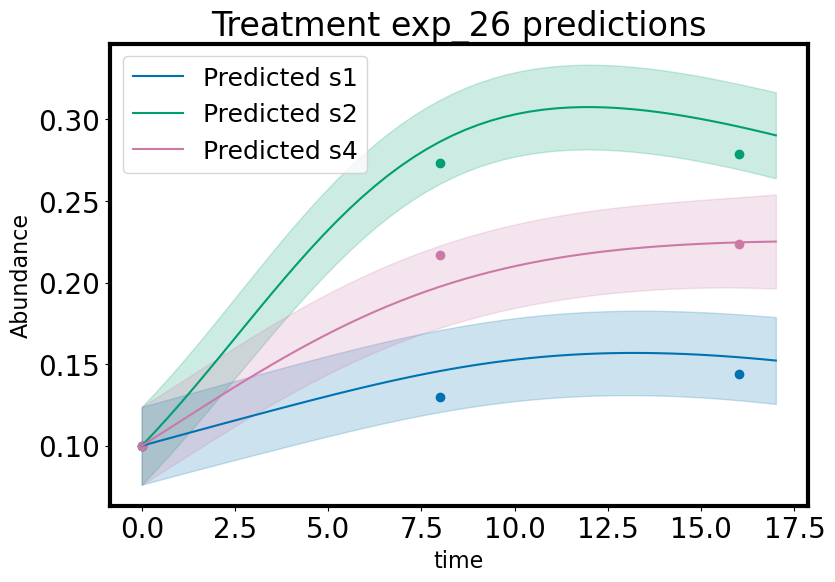

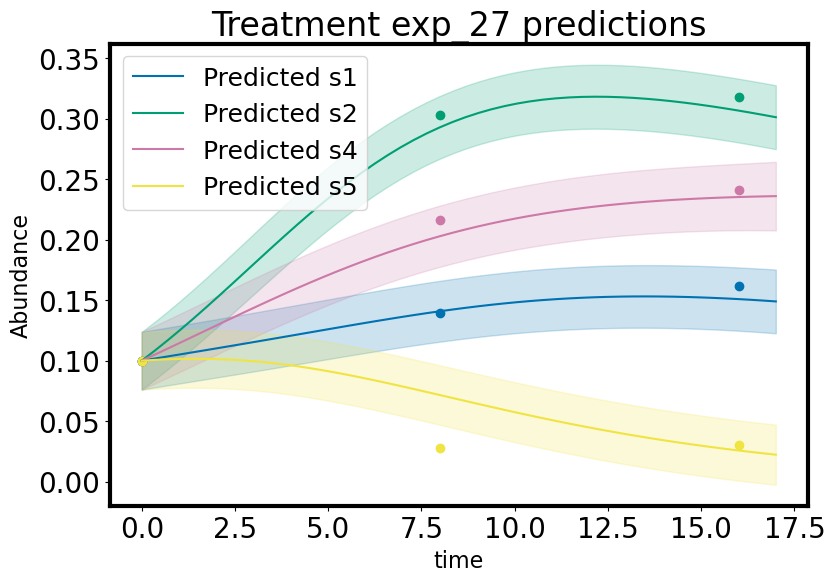

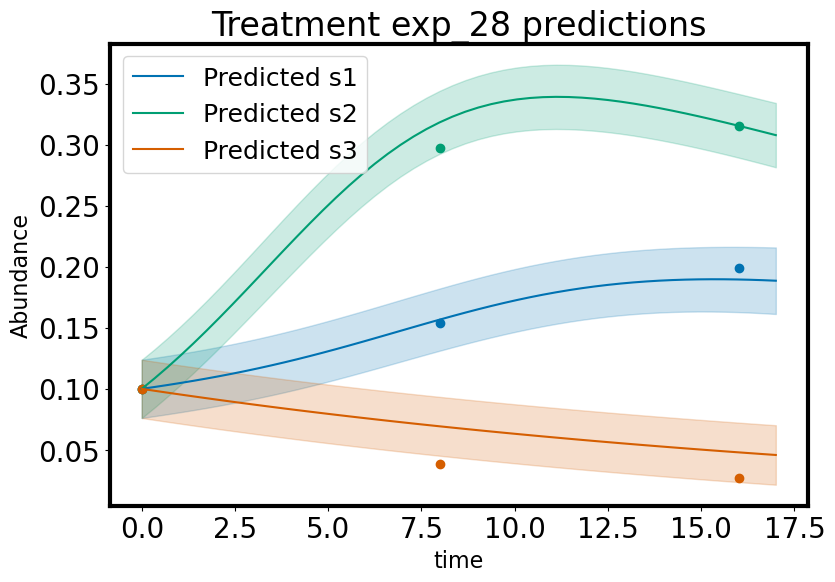

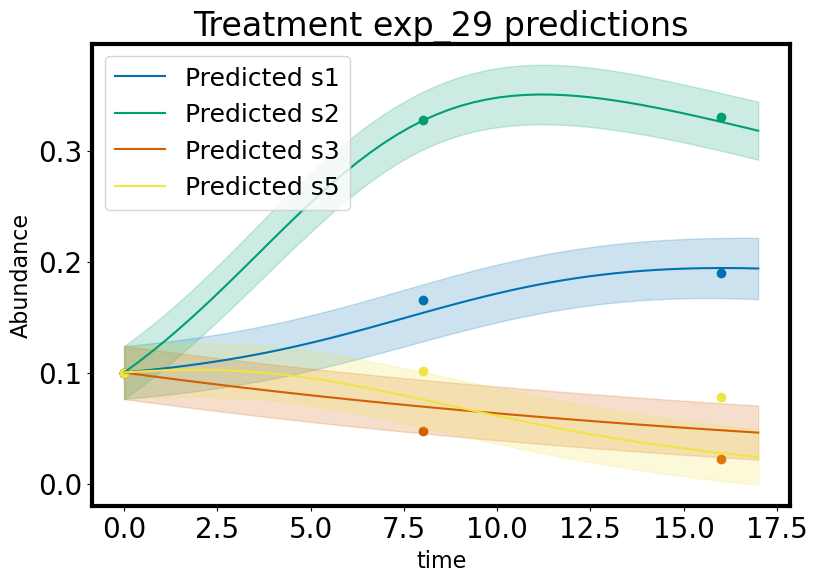

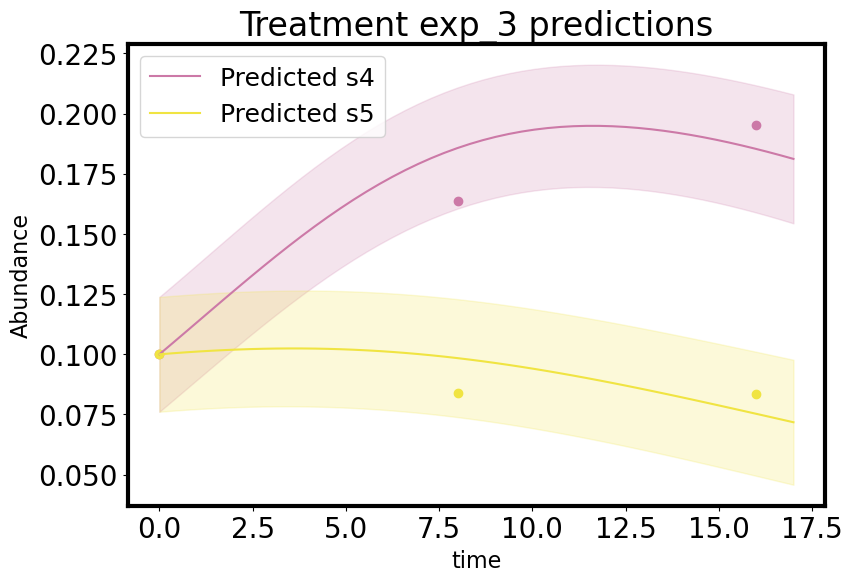

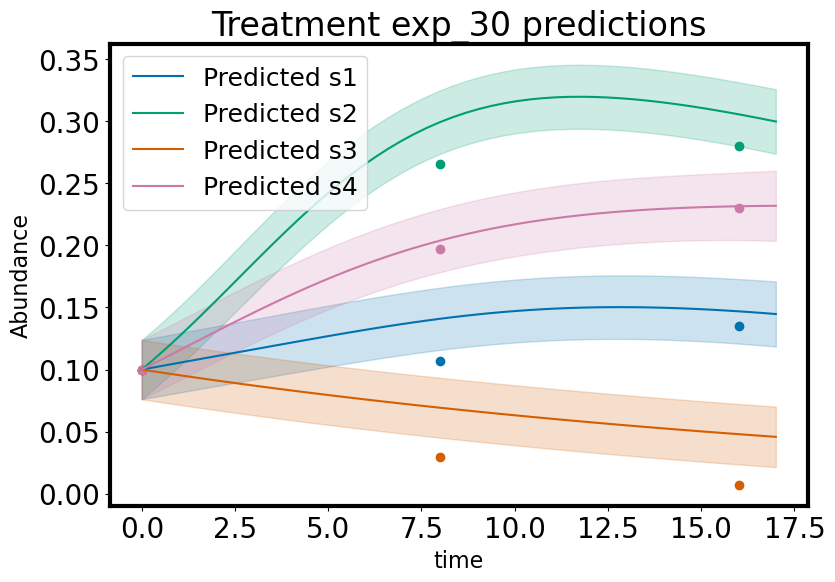

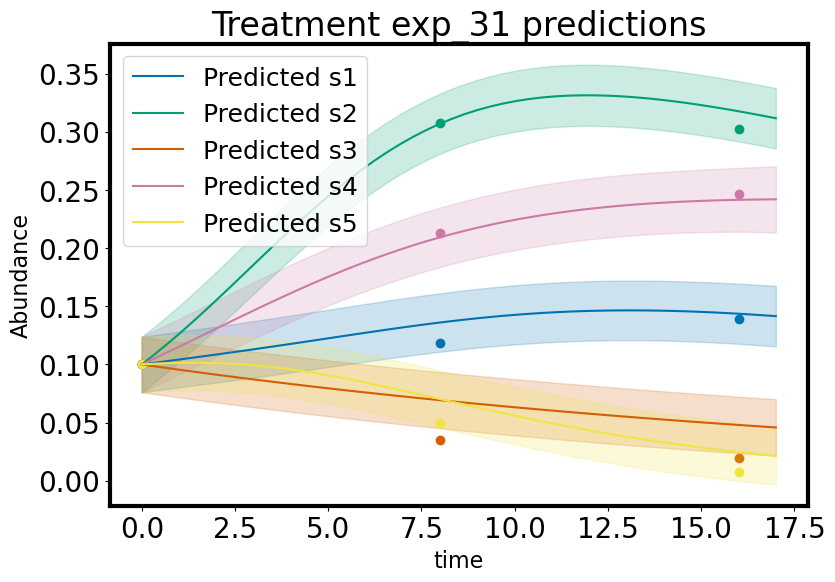

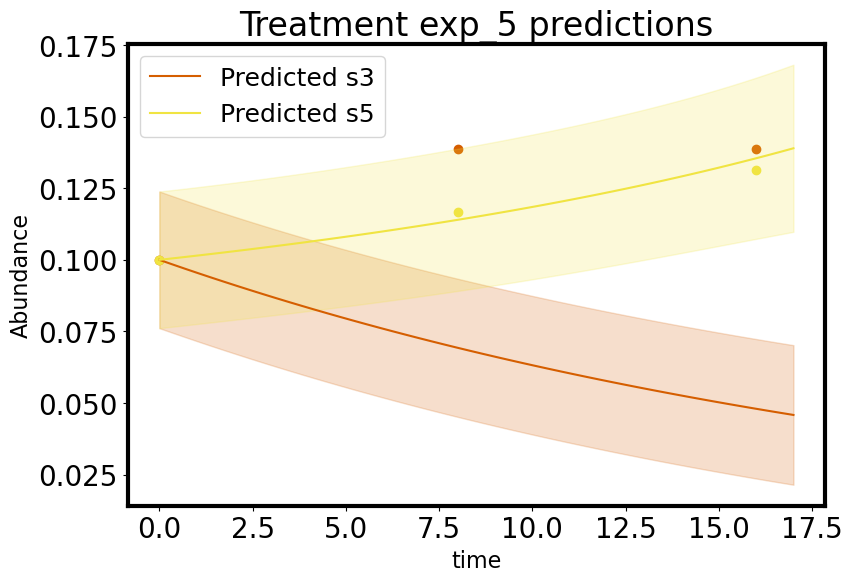

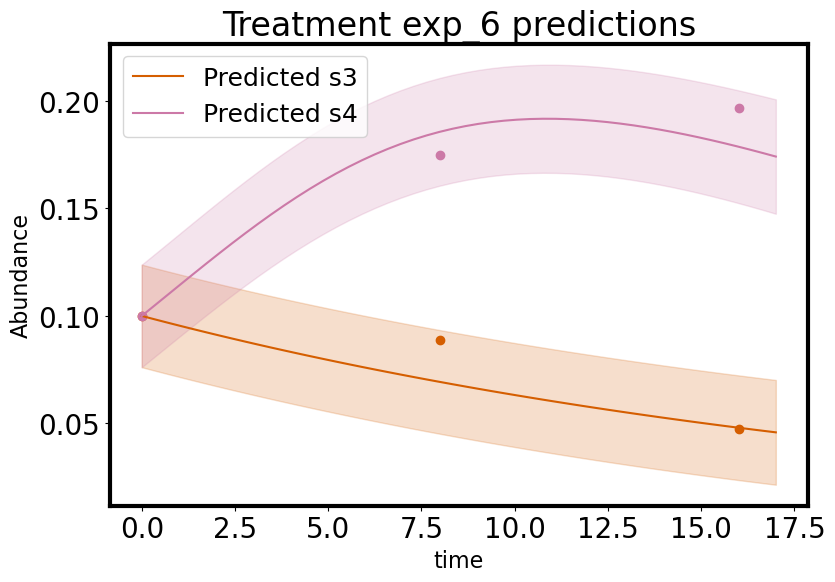

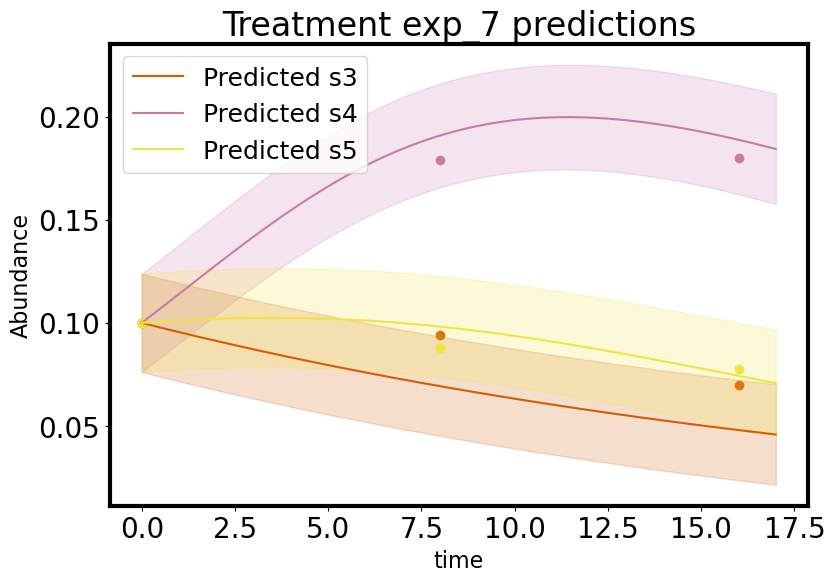

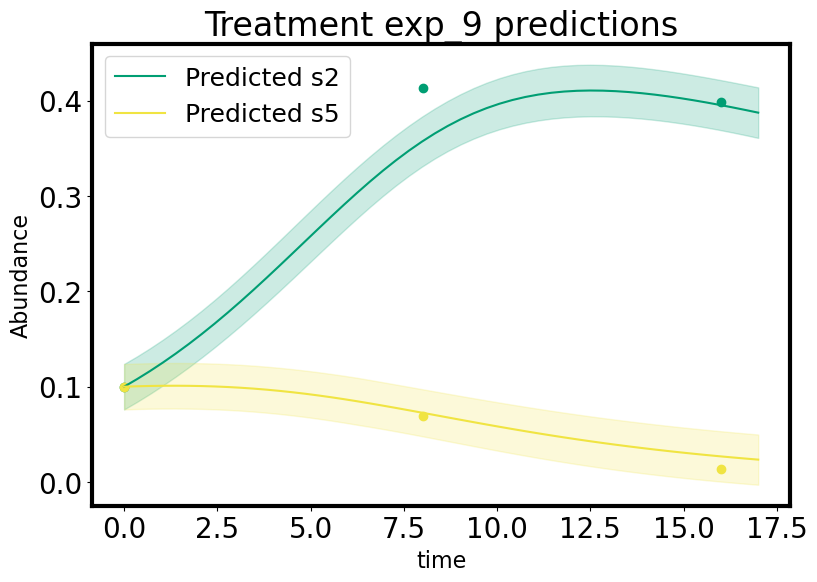

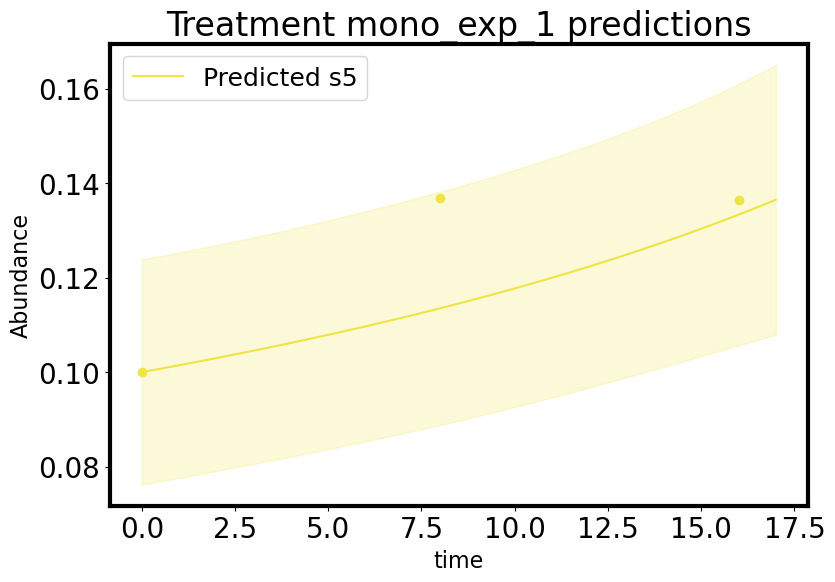

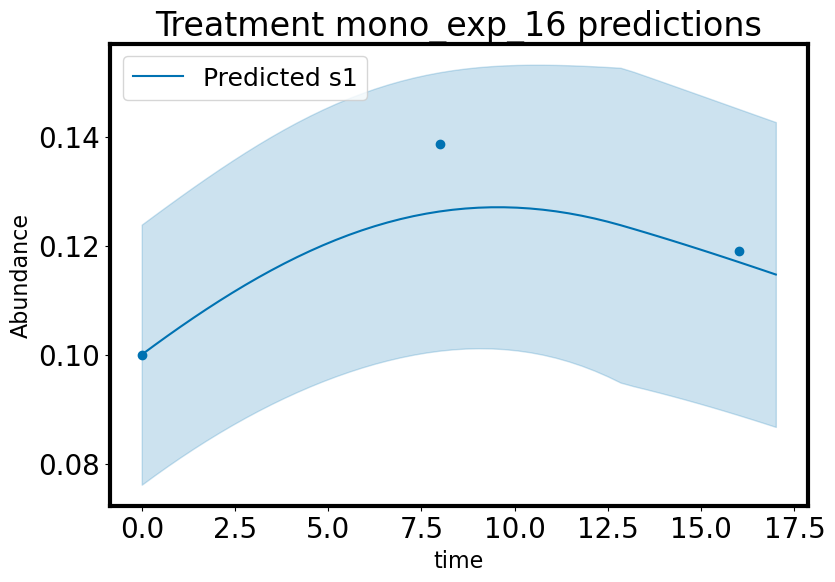

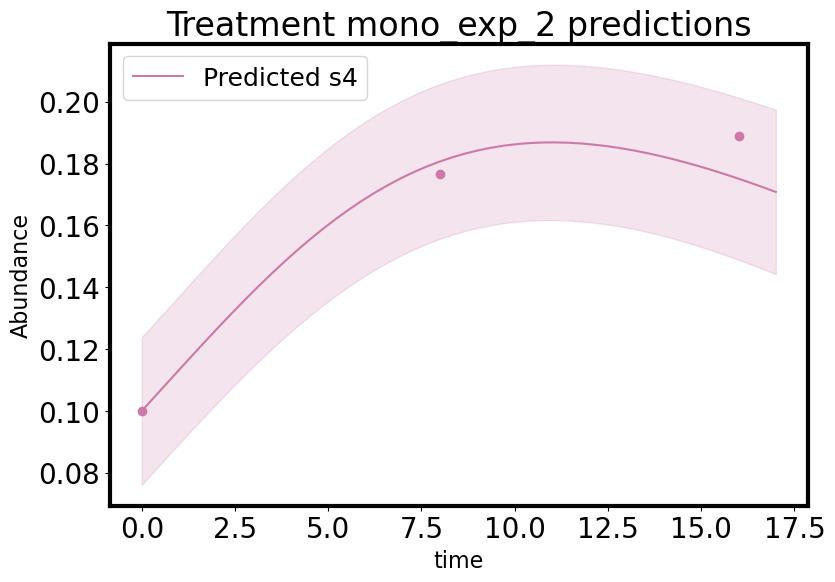

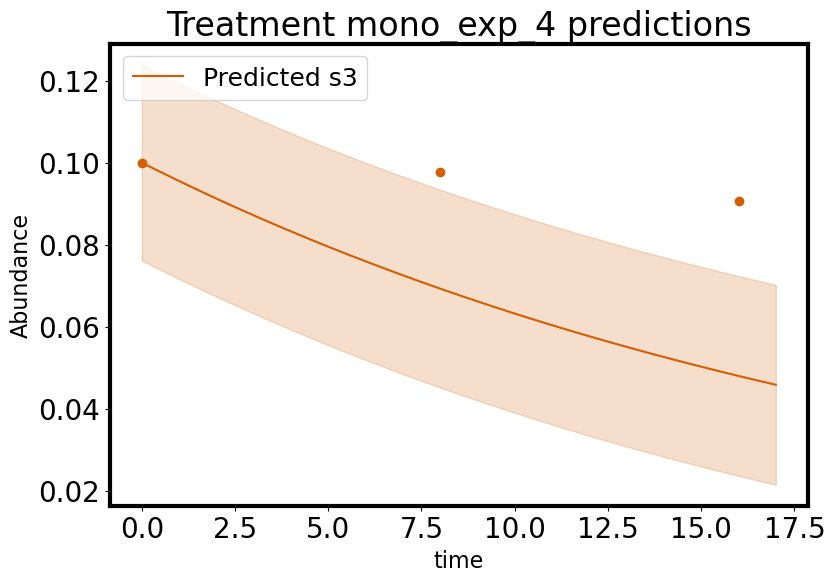

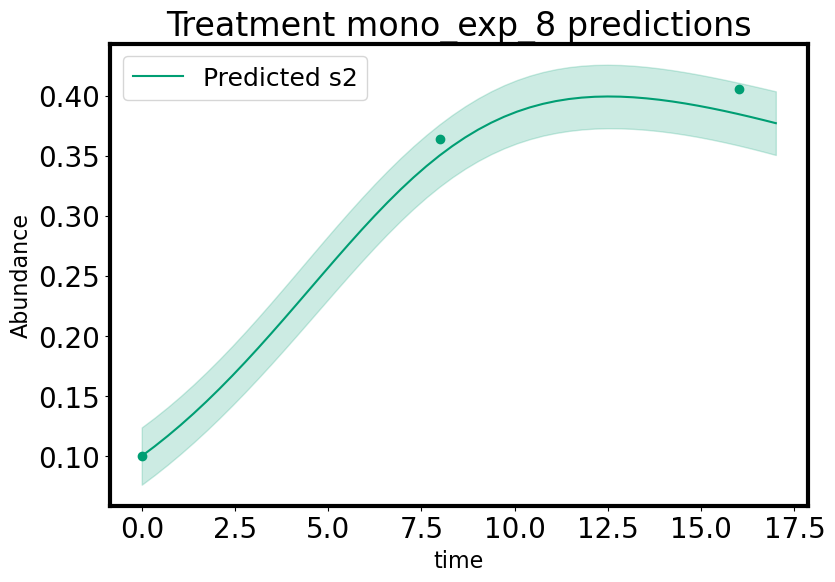

In [10]:
test_treatments, test_times, all_species_names, y_true, y_pred = test_model(model, gLV_data, species, plot=True)
# R = linregress(y_true, y_pred).rvalue
# plt.scatter(y_true, y_pred, label="R = {:.2f}".format(R))
# plt.xlabel("True")
# plt.ylabel("Predicted")
# plt.legend()
# plt.show()

In [11]:
np.sqrt(1/model.beta)

0.023848405

In [12]:
r0 = model.params[:n_r]
#params = model.params[n_r:]
#death_rate = params[:n_s]
#C = jnp.reshape(params[n_s:n_s+n_s*n_r], [n_r, n_s])
#P = jnp.reshape(params[n_s+n_s*n_r:], [n_r, n_s])

In [13]:
r0

array([-0.81028406, -1.32924356, -2.07908263])

In [14]:
params = model.params[n_r:]

In [15]:
params

array([ 3.42038123e-02,  2.94581905e-02,  4.58629587e-02,  5.98620681e-02,
        1.52133205e-01,  1.01659363e+00, -4.51370407e-01, -5.34531978e-01,
       -4.81928470e-01,  1.30375369e-01,  2.87583199e-01,  9.05408928e-01,
       -1.53605951e-01,  4.50042482e-01,  5.18993409e-01,  1.35873314e-01,
        7.55638115e-01, -7.66966879e-01, -8.74923546e-01, -2.78263225e-01,
        8.12786235e-01,  5.12313667e-01,  5.86595528e-01,  9.35178308e-01,
       -1.13373889e-01,  1.85746524e-01,  5.30723343e-01,  2.66739642e-01,
        3.17276266e-01, -1.14058103e-01,  4.51602398e-01,  1.18328152e+00,
        1.82855502e-01,  1.06697496e+00, -1.01141807e+00, -7.55716410e-01,
        6.49959199e-01,  9.61244756e-01, -9.50700159e-01, -2.45096487e-02,
        4.28972788e-02,  1.59297514e-01, -1.01496316e+00,  6.59117570e-01,
        7.51410482e-01,  1.92212071e-01,  2.68236432e-01,  6.20378818e-01,
       -8.08062949e-01, -5.62099913e-01, -4.82561877e-01, -6.37884921e-02,
       -8.12535948e-02,  